In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

def lm_func(t,p):
    """
    Define model function used for nonlinear least squares curve-fitting.
    Parameters
    ----------
    t     : independent variable values (assumed to be error-free) (m x 1)
    p     : parameter values , n = 4 in these examples             (n x 1)
    Returns
    -------
    y_hat : curve-fit fctn evaluated at points t and with parameters p (m x 1)
    """
    y_hat = p[0,0] * np.exp(t * p[1,0])

    return y_hat

def lm_FD_J(t,p,y,dp):
    """
    Computes partial derivates (Jacobian) dy/dp via finite differences.
    Parameters
    ----------
    t  :     independent variables used as arg to lm_func (m x 1) 
    p  :     current parameter values (n x 1)
    y  :     func(t,p,c) initialised by user before each call to lm_FD_J (m x 1)
    dp :     fractional increment of p for numerical derivatives
                - dp(j)>0 central differences calculated
                - dp(j)<0 one sided differences calculated
                - dp(j)=0 sets corresponding partials to zero; i.e. holds p(j) fixed
    Returns
    -------
    J :      Jacobian Matrix (n x m)
    """

    global func_calls
    
    # number of data points
    m = len(y)
    # number of parameters
    n = len(p)

    # initialize Jacobian to Zero
    ps=p
    J=np.zeros((m,n)) 
    del_=np.zeros((n,1))
    
    # START --- loop over all parameters
    for j in range(n):
        # parameter perturbation
        del_[j,0] = dp[j,0] * (1+abs(p[j,0]))
        # perturb parameter p(j)
        p[j,0]   = ps[j,0] + del_[j,0]
        
        if del_[j,0] != 0:
            y1 = lm_func(t,p)
            func_calls = func_calls + 1
            
            if dp[j,0] < 0: 
                # backwards difference
                J[:,j] = (y1-y)/del_[j,0]
            else:
                # central difference, additional func call
                p[j,0] = ps[j,0] - del_[j]
                J[:,j] = (y1-lm_func(t,p)) / (2 * del_[j,0])
                func_calls = func_calls + 1
        # restore p(j)
        p[j,0]=ps[j,0]
        
    return J

def lm_Broyden_J(p_old,y_old,J,p,y):
    """
    Carry out a rank-1 update to the Jacobian matrix using Broyden's equation.

    Parameters
    ----------
    p_old :     previous set of parameters (n x 1)
    y_old :     model evaluation at previous set of parameters, y_hat(t,p_old) (m x 1)
    J     :     current version of the Jacobian matrix (m x n)
    p     :     current set of parameters (n x 1)
    y     :     model evaluation at current  set of parameters, y_hat(t,p) (m x 1)

    Returns
    -------
    J     :     rank-1 update to Jacobian Matrix J(i,j)=dy(i)/dp(j) (m x n)

    """
    h = p - p_old
    
    a = (np.array([y - y_old]).T - J@h)@h.T
    b = h.T@h

    # Broyden rank-1 update eq'n
    J = J + a/b
    return J

def lm_matx(t,p_old,y_old,dX2,J,p,y_dat,weight,dp):
    """
    Evaluate the linearized fitting matrix, JtWJ, and vector JtWdy, and 
    calculate the Chi-squared error function, Chi_sq used by Levenberg-Marquardt 
    algorithm (lm).
    
    Parameters
    ----------
    t      :     independent variables used as arg to lm_func (m x 1)
    p_old  :     previous parameter values (n x 1)
    y_old  :     previous model ... y_old = y_hat(t,p_old) (m x 1)
    dX2    :     previous change in Chi-squared criteria (1 x 1)
    J      :     Jacobian of model, y_hat, with respect to parameters, p (m x n)
    p      :     current parameter values (n x 1)
    y_dat  :     data to be fit by func(t,p,c) (m x 1)
    weight :     the weighting vector for least squares fit inverse of 
                 the squared standard measurement errors
    dp     :     fractional increment of 'p' for numerical derivatives
                  - dp(j)>0 central differences calculated
                  - dp(j)<0 one sided differences calculated
                  - dp(j)=0 sets corresponding partials to zero; i.e. holds p(j) fixed

    Returns
    -------
    JtWJ   :     linearized Hessian matrix (inverse of covariance matrix) (n x n)
    JtWdy  :     linearized fitting vector (n x m)
    Chi_sq :     Chi-squared criteria: weighted sum of the squared residuals WSSR
    y_hat  :     model evaluated with parameters 'p' (m x 1)
    J :          Jacobian of model, y_hat, with respect to parameters, p (m x n)

    """
    
    global iteration,func_calls
    
    # number of parameters
    Npar   = len(p)

    # evaluate model using parameters 'p'
    y_hat = lm_func(t,p)
    
    func_calls = func_calls + 1

    if not np.remainder(iteration,2*Npar) or dX2 > 0:
        # finite difference
        J = lm_FD_J(t,p,y_hat,dp)
    else:
        # rank-1 update
        J = lm_Broyden_J(p_old,y_old,J,p,y_hat)

    # residual error between model and data
    delta_y = np.array([y_dat - y_hat]).T
    
    # Chi-squared error criteria
    Chi_sq = delta_y.T @ ( delta_y * weight )  

    JtWJ  = J.T @ ( J * ( weight * np.ones((1,Npar)) ) )
    
    JtWdy = J.T @ ( weight * delta_y )
    return JtWJ,JtWdy,Chi_sq,y_hat,J

In [44]:
def lm(p,t,y_dat):  
    """
    
    Levenberg Marquardt curve-fitting: minimize sum of weighted squared residuals

    Parameters
    ----------
    p : initial guess of parameter values (n x 1)
    t : independent variables (used as arg to lm_func) (m x 1)
    y_dat : data to be fit by func(t,p) (m x 1)

    Returns
    -------
    p       : least-squares optimal estimate of the parameter values
    redX2   : reduced Chi squared error criteria - should be close to 1
    sigma_p : asymptotic standard error of the parameters
    sigma_y : asymptotic standard error of the curve-fit
    corr_p  : correlation matrix of the parameters
    R_sq    : R-squared cofficient of multiple determination  
    cvg_hst : convergence history (col 1: function calls, col 2: reduced chi-sq,
              col 3 through n: parameter values). Row number corresponds to
              iteration number.

    """

    global iteration, func_calls
    
    # iteration counter
    iteration  = 0
    # running count of function evaluations
    func_calls = 0
    
    # define eps (not available in python)
    eps = 2**(-52)

    # number of parameters
    Npar   = len(p)
    # number of data points
    Npnt   = len(y_dat)
    # previous set of parameters
    p_old  = np.zeros((Npar,1))
    # previous model, y_old = y_hat(t,p_old)
    y_old  = np.zeros((Npnt,1))
    # a really big initial Chi-sq value
    X2     = 1e-3/eps
    # a really big initial Chi-sq value
    X2_old = 1e-3/eps
    # Jacobian matrix
    J      = np.zeros((Npnt,Npar))
    # statistical degrees of freedom
    DoF    = np.array([[Npnt - Npar + 1]])
    
    
    if len(t) != len(y_dat):
        print('The length of t must equal the length of y_dat!')
        X2 = 0 
        corr_p = 0 
        sigma_p = 0 
        sigma_y = 0
        R_sq = 0

    # weights or a scalar weight value ( weight >= 0 )
    weight = 1/(y_dat.T@y_dat)
    # fractional increment of 'p' for numerical derivatives
    dp = [-0.001]      
    # lower bounds for parameter values
    p_min = -100*abs(p)  
    # upper bounds for parameter values       
    p_max = 100*abs(p)

    MaxIter       = 10000        # maximum number of iterations
    epsilon_1     = 1e-3        # convergence tolerance for gradient
    epsilon_2     = 1e-4        # convergence tolerance for parameters
    epsilon_4     = 1e-4        # determines acceptance of a L-M step
    lambda_0      = 1e-2        # initial value of damping paramter, lambda
    lambda_UP_fac = 11          # factor for increasing lambda
    lambda_DN_fac = 9           # factor for decreasing lambda
    Update_Type   = 1           # 1: Levenberg-Marquardt lambda update, 2: Quadratic update, 3: Nielsen's lambda update equations 

    if len(dp) == 1:
        dp = dp*np.ones((Npar,1))

    idx   = np.arange(len(dp))  # indices of the parameters to be fit
    stop = 0                    # termination flag

    # identical weights vector
    if np.var(weight) == 0:         
        weight = abs(weight)*np.ones((Npnt,1))        
        print('Using uniform weights for error analysis')
    else:
        weight = abs(weight)

    # initialize Jacobian with finite difference calculation
    JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,1,J,p,y_dat,weight,dp)
    if np.abs(JtWdy).max() < epsilon_1:
        print('*** Your Initial Guess is Extremely Close to Optimal ***')
    
    lambda_0 = np.atleast_2d([lambda_0])

    # Marquardt: init'l lambda
    if Update_Type == 1:
        lambda_  = lambda_0
    # Quadratic and Nielsen
    else:
        lambda_  = lambda_0 * max(np.diag(JtWJ))
        nu=2
    
    # previous value of X2 
    X2_old = X2
    # initialize convergence history
    cvg_hst = np.ones((MaxIter,Npar+2))   
    
    # -------- Start Main Loop ----------- #
    while not stop and iteration <= MaxIter:
        
        iteration += 1
 
        # incremental change in parameters
        # Marquardt
        if Update_Type == 1:
            h = np.linalg.solve((JtWJ + lambda_*np.diag(np.diag(JtWJ)) ), JtWdy)  
        # Quadratic and Nielsen
        else:
            h = np.linalg.solve(( JtWJ + lambda_*np.eye(Npar) ), JtWdy)

        # update the [idx] elements
        p_try = p + h[idx]
        # apply constraints                             
        p_try = np.minimum(np.maximum(p_min,p_try),p_max)       
    
        # residual error using p_try
        delta_y = np.array([y_dat - lm_func(t,p_try)]).T
        
        # floating point error; break       
        if not all(np.isfinite(delta_y)):                   
          stop = 1
          break     

        func_calls = func_calls + 1
        # Chi-squared error criteria
        X2_try = delta_y.T @ ( delta_y * weight )
        
        # % Quadratic
        if Update_Type == 2:                        
          # One step of quadratic line update in the h direction for minimum X2
          alpha =  np.divide(JtWdy.T @ h, ( (X2_try - X2)/2 + 2*JtWdy.T@h ))
          h = alpha * h
          
          # % update only [idx] elements
          p_try = p + h[idx]
          # % apply constraints
          p_try = np.minimum(np.maximum(p_min,p_try),p_max)         
          
          # % residual error using p_try
          delta_y = y_dat - lm_func(t,p_try)     
          func_calls = func_calls + 1
          # % Chi-squared error criteria
          X2_try = delta_y.T @ ( delta_y * weight )   
  
        rho = np.matmul( h.T @ (lambda_ * h + JtWdy),np.linalg.inv(X2 - X2_try))
    
        # it IS significantly better
        if ( rho > epsilon_4 ):                         
    
            dX2 = X2 - X2_old
            X2_old = X2
            p_old = p
            y_old = y_hat
            # % accept p_try
            p = p_try                        
        
            JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,dX2,J,p,y_dat,weight,dp)
            
            # % decrease lambda ==> Gauss-Newton method
            # % Levenberg
            if Update_Type == 1:
                lambda_ = max(lambda_/lambda_DN_fac,1.e-7)
            # % Quadratic
            elif Update_Type == 2:
                lambda_ = max( lambda_/(1 + alpha) , 1.e-7 )
            # % Nielsen
            else:
                lambda_ = lambda_*max( 1/3, 1-(2*rho-1)**3 )
                nu = 2
            
        # it IS NOT better
        else:                                           
            # % do not accept p_try
            X2 = X2_old
    
            if not np.remainder(iteration,2*Npar):            
                JtWJ,JtWdy,dX2,y_hat,J = lm_matx(t,p_old,y_old,-1,J,p,y_dat,weight,dp)
    
            # % increase lambda  ==> gradient descent method
            # % Levenberg
            if Update_Type == 1:
                lambda_ = min(lambda_*lambda_UP_fac,1.e7)
            # % Quadratic
            elif Update_Type == 2:
                lambda_ = lambda_ + abs((X2_try - X2)/2/alpha)
            # % Nielsen
            else:
                lambda_ = lambda_ * nu
                nu = 2*nu

        # update convergence history ... save _reduced_ Chi-square
        cvg_hst[iteration-1,0] = func_calls
        cvg_hst[iteration-1,1] = X2/DoF
        
        for i in range(Npar):
            cvg_hst[iteration-1,i+2] = p.T[0][i]

        if ( max(abs(JtWdy)) < epsilon_1  and  iteration > 2 ):
          print('**** Convergence in r.h.s. ("JtWdy")  ****')
          stop = 1
    
        if ( max(abs(h)/(abs(p)+1e-12)) < epsilon_2  and  iteration > 2 ): 
          print('**** Convergence in Parameters ****')
          stop = 1
    
        if ( iteration == MaxIter ):
          print('!! Maximum Number of Iterations Reached Without Convergence !!')
          stop = 1

        # --- End of Main Loop --- #
        # --- convergence achieved, find covariance and confidence intervals

    #  ---- Error Analysis ----
    #  recompute equal weights for paramter error analysis
    if np.var(weight) == 0:   
        weight = DoF/(delta_y.T@delta_y) * np.ones((Npnt,1))
      
    # % reduced Chi-square                            
    redX2 = X2 / DoF

    JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,-1,J,p,y_dat,weight,dp)

    # standard error of parameters 
    covar_p = np.linalg.inv(JtWJ)
    sigma_p = np.sqrt(np.diag(covar_p)) 
    error_p = sigma_p/p
    
    # standard error of the fit
    sigma_y = np.zeros((Npnt,1))
    for i in range(Npnt):
        sigma_y[i,0] = J[i,:] @ covar_p @ J[i,:].T        

    sigma_y = np.sqrt(sigma_y)

    # parameter correlation matrix
    corr_p = covar_p / [sigma_p@sigma_p.T]
        
    # coefficient of multiple determination
    R_sq = np.correlate(y_dat, y_hat)
    R_sq = 0        

    # convergence history
    cvg_hst = cvg_hst[:iteration,:]
    
    print('\nLM fitting results:')
    for i in range(Npar):
        print('----------------------------- ')
        print('parameter      = p%i' %(i+1))
        print('fitted value   = %0.4f' % p[i,0])
        print('standard error = %0.2f %%' % error_p[i,0])
    
    return p,redX2,sigma_p,sigma_y,corr_p,R_sq,cvg_hst

In [295]:
def main(x,y,p_init):
    # minimize sum of weighted squared residuals with L-M least squares analysis
    p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst = lm(p_init,x,y)
    
    return p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst


In [457]:
with open('Mx_1x10/USA.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

years_of_interes = ["1933-1939", "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

x = datos_generales["Ages"][40:60]
x = x
y = datos_generales["1933-1939"][40:60]

# Fit Gompertz Law

In [458]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

In [459]:
R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

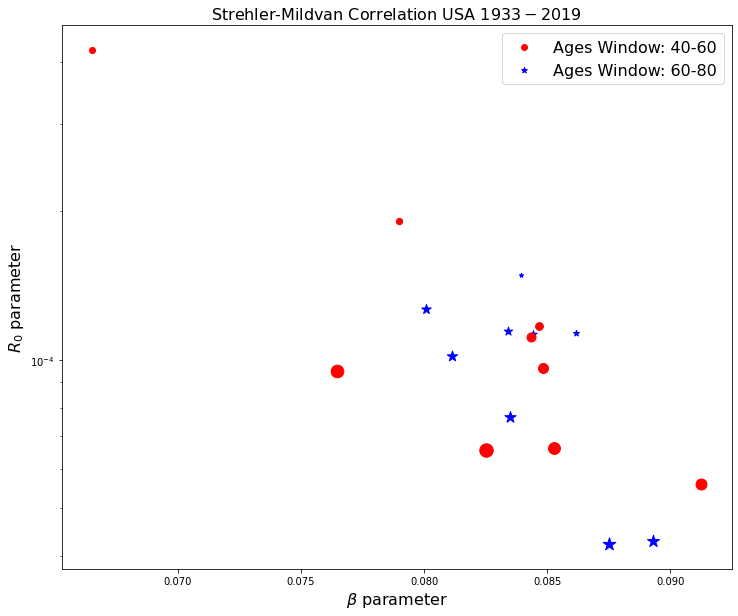

In [460]:
plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation USA $1933-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

colores = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_USA.jpg", dpi = 500)

# FIT JPN

In [452]:
with open('Mx_1x10/JPN.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

years_of_interes = ["1947-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2021"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [453]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

In [454]:
R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

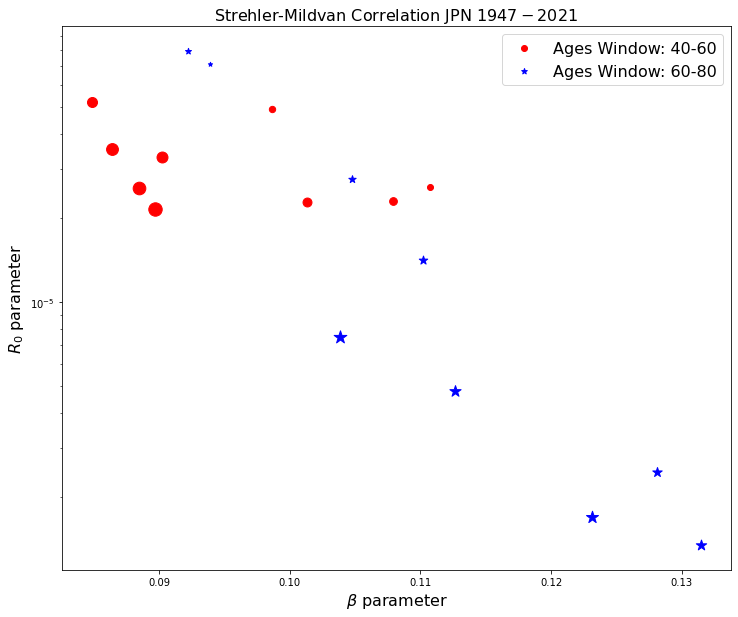

In [455]:
plt.figure(figsize = (12,10))
plt.title(fr"Strehler-Mildvan Correlation JPN $1947-2021$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

colores = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_JPN.jpg", dpi = 500)

# FIT CAN

In [448]:
with open('Mx_1x10/CAN.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

years_of_interes = ["1921-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [449]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x)

In [450]:
R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

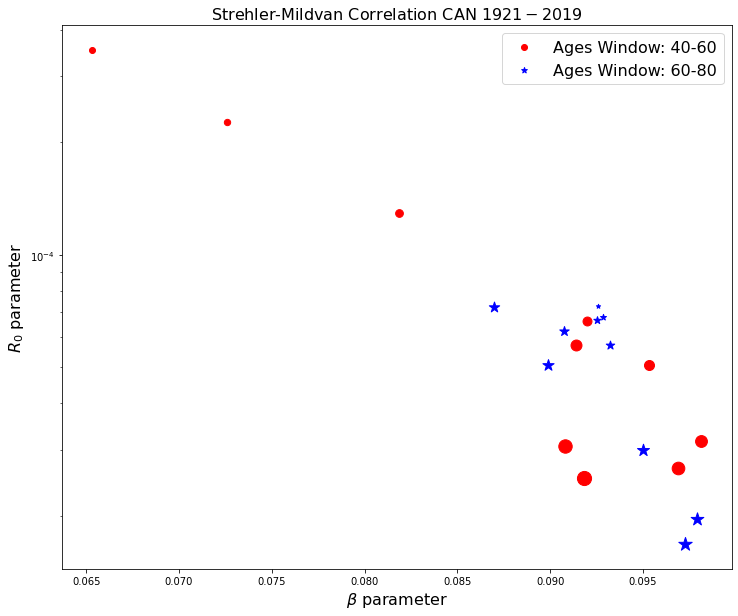

In [451]:
plt.figure(figsize = (12,10))
plt.title(fr"Strehler-Mildvan Correlation CAN $1921-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_CAN.jpg", dpi = 500)

# FIT SWE

In [462]:
with open('Mx_1x10/SWE.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1751-1759", "1760-1769", "1770-1779", "1780-1789", "1790-1799", "1800-1809", "1810-1819", "1820-1829", "1830-1839", "1840-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909" ,"1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2022"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [463]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

In [464]:
R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

In [465]:
distancia_euclidea_Strehler_Mildvan_correlation = []
for i in range(len(betas_gompertz_law_60_80)):
    distancia = np.sqrt((betas_gompertz_law_60_80[i] - betas_gompertz_law_40_60[i] )**2 + (R_parameter_gompertz_law_60_80[i]-R_parameter_gompertz_law_40_60[i])**2)
    distancia_euclidea_Strehler_Mildvan_correlation.append(distancia)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


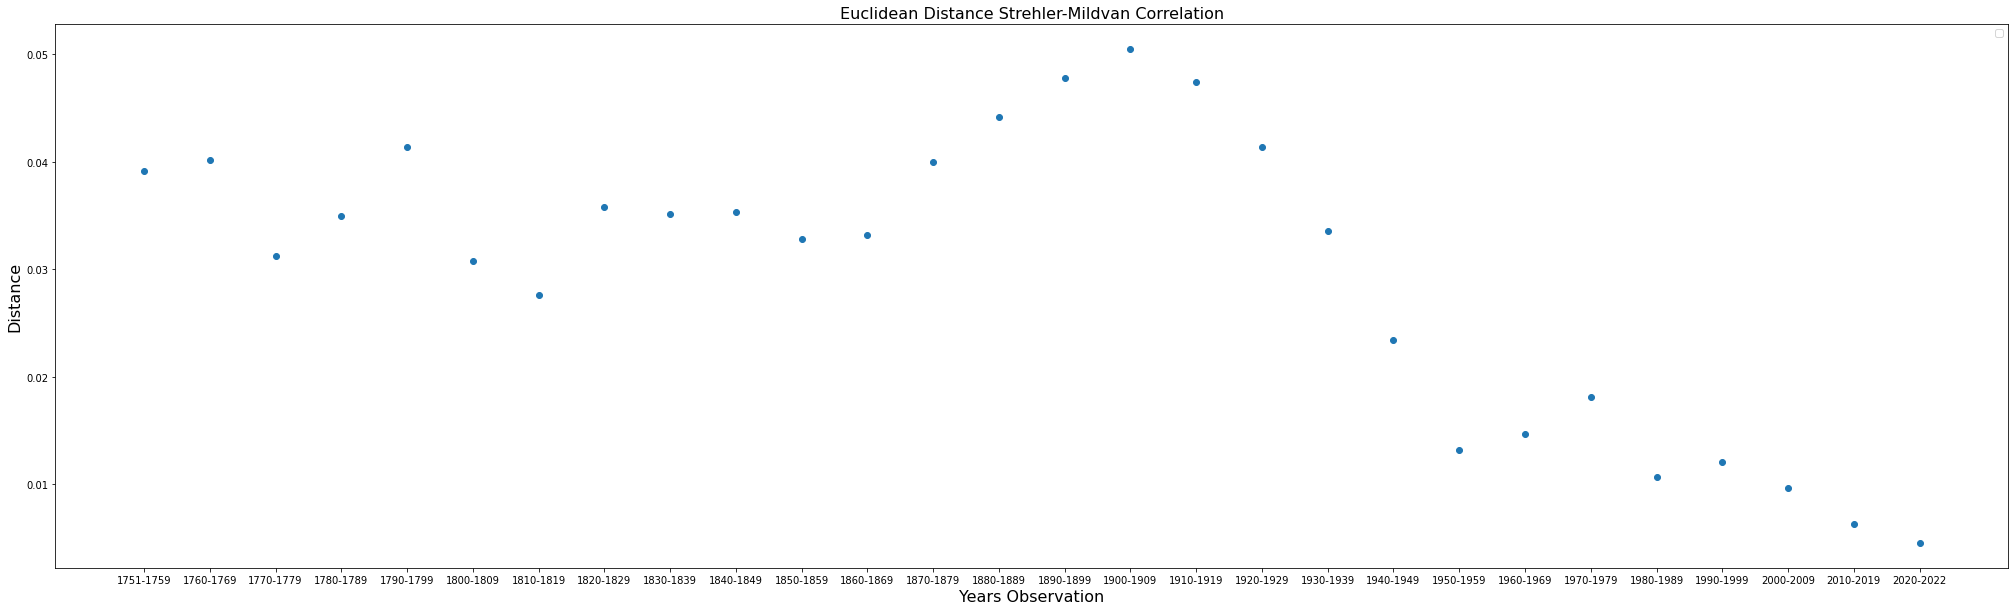

In [475]:
plt.figure(figsize=(35,10))
plt.title(r"Euclidean Distance Strehler-Mildvan Correlation", fontsize = 16)
plt.xlabel(r"Years Observation", fontsize = 16)
plt.ylabel(r"Distance", fontsize = 16)
plt.scatter(years_of_interes, distancia_euclidea_Strehler_Mildvan_correlation)
plt.legend()

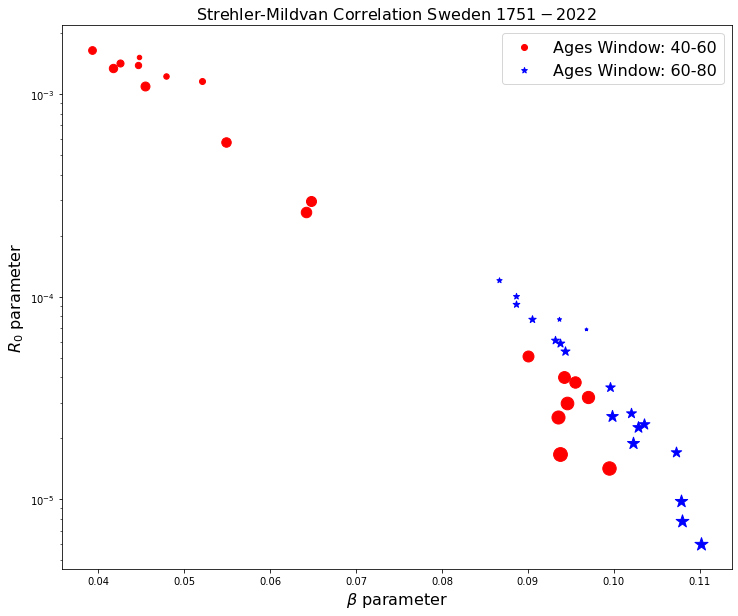

In [447]:
plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Sweden $1751-2022$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_SWE.jpg", dpi = 500)

# FIT AUS

In [395]:
with open('Mx_1x10/AUS.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = [ "1921-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

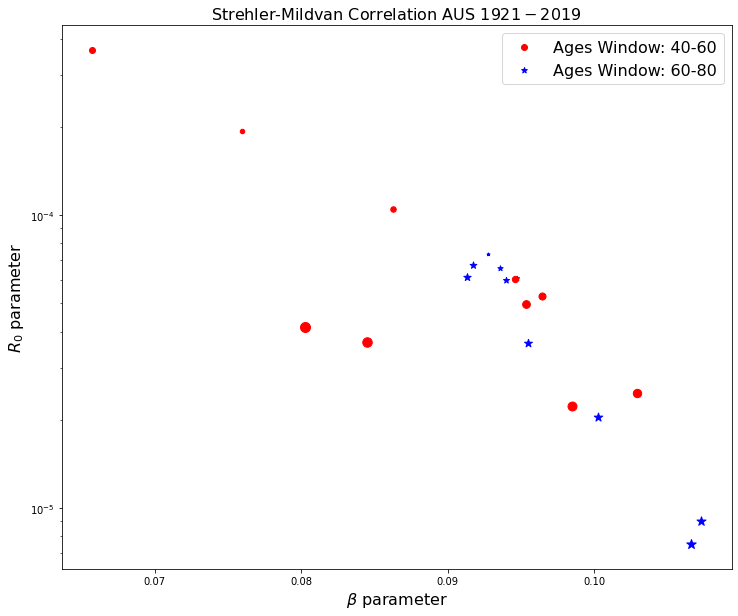

In [399]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation AUS $1921-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_AUS.jpg", dpi = 500)

# FIT BELGIUM

In [400]:
with open('Mx_1x10/BEL.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1841-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909" ,"1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2021"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

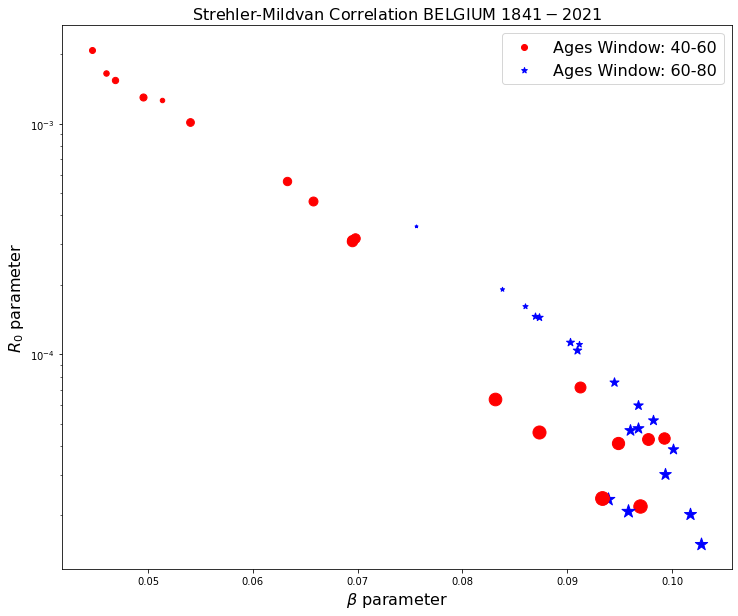

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation BELGIUM $1841-2021$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_BEL.jpg", dpi = 500)

# FIT CHE Switerzland

In [403]:
with open('Mx_1x10/CHE.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1876-1879", "1880-1889", "1890-1899", "1900-1909" ,"1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2021"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

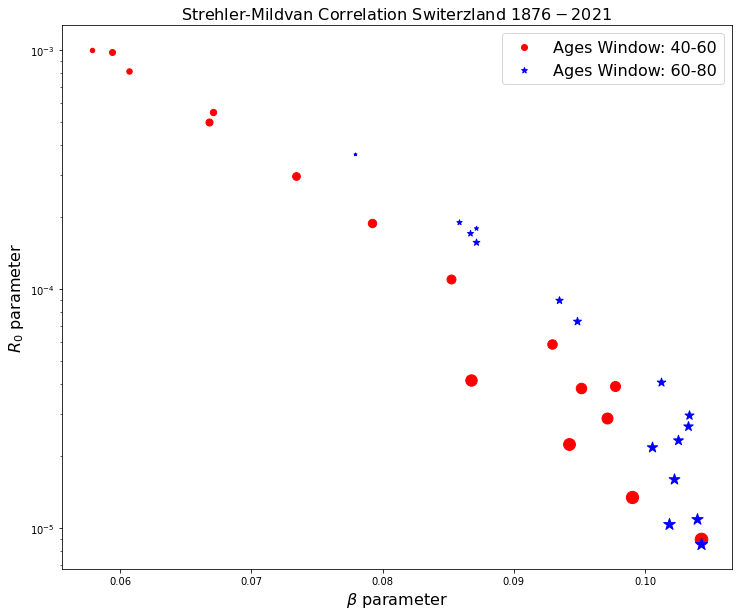

In [404]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(fr"Strehler-Mildvan Correlation Switerzland $1876-2021$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Switerzland.jpg", dpi = 500)

# FIT DNK Denmark

In [414]:
with open('Mx_1x10/DNK.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1835-1839", "1840-1849","1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909" ,"1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2022"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

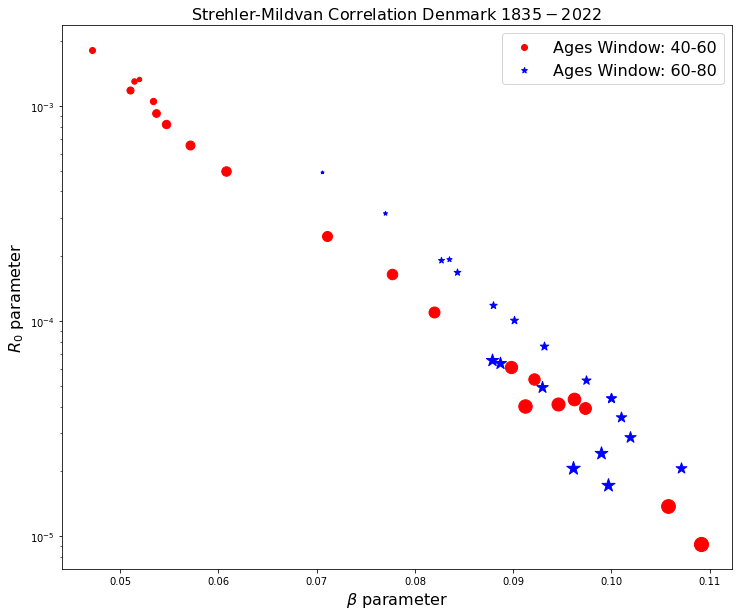

In [415]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(fr"Strehler-Mildvan Correlation Denmark $1835-2022$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_DNK.jpg", dpi = 500)

# Fit Spain

In [416]:
with open('Mx_1x10/ESP.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = [ "1908-1909" ,"1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

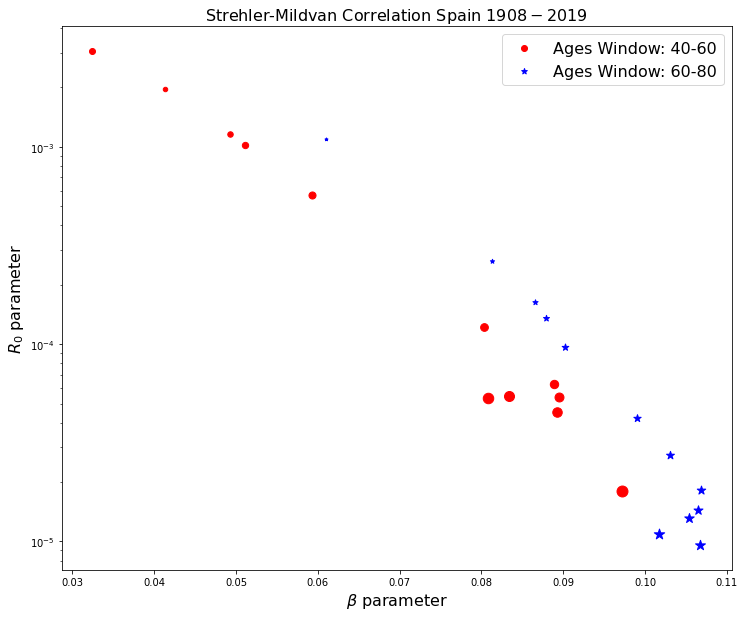

In [417]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Spain $1908-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Spain.jpg", dpi = 500)

# FIT FIN Finlandia

In [418]:
with open('Mx_1x10/FIN.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1878-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

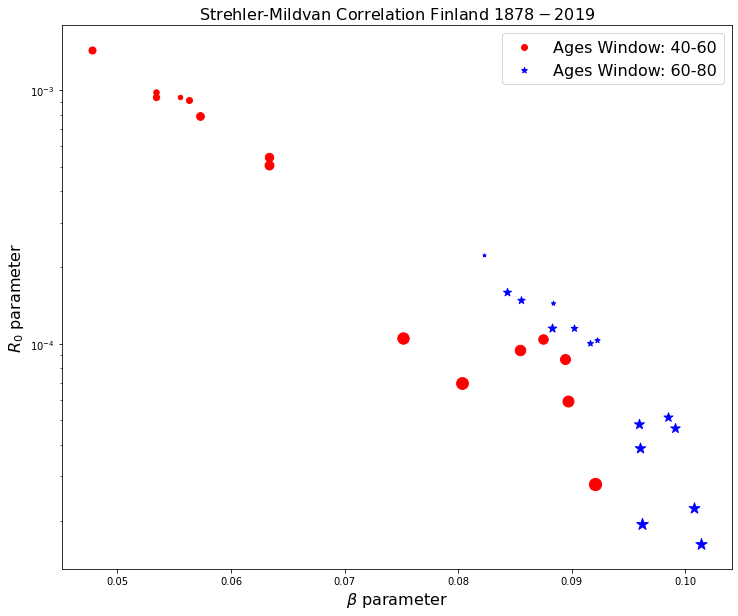

In [419]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(fr"Strehler-Mildvan Correlation Finland $1878-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Fin.jpg", dpi = 500)

# FIT FRATNP

In [422]:
with open('Mx_1x10/FRATNP.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1816-1819", "1820-1829", "1830-1839", "1840-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

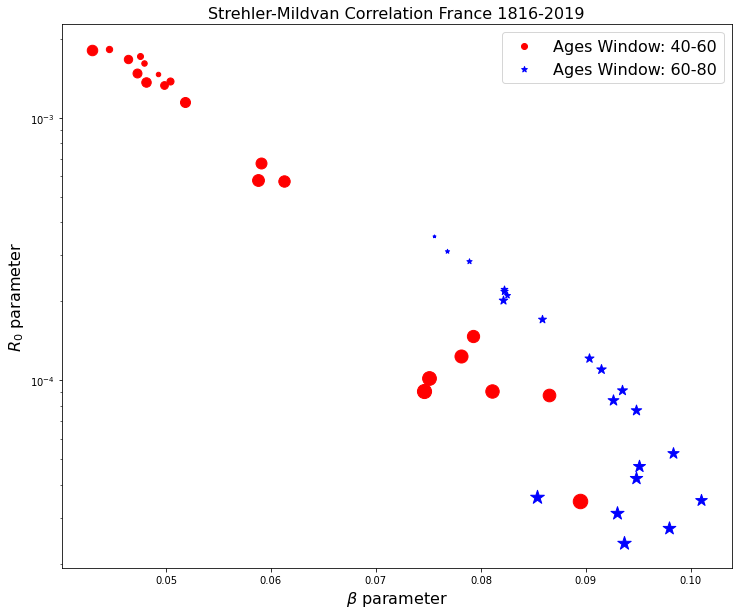

In [423]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(r"Strehler-Mildvan Correlation France 1816-2019" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_France.jpg", dpi = 500)

# FIT GBRTENW

In [424]:
with open('Mx_1x10/GBRTENW.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1841-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

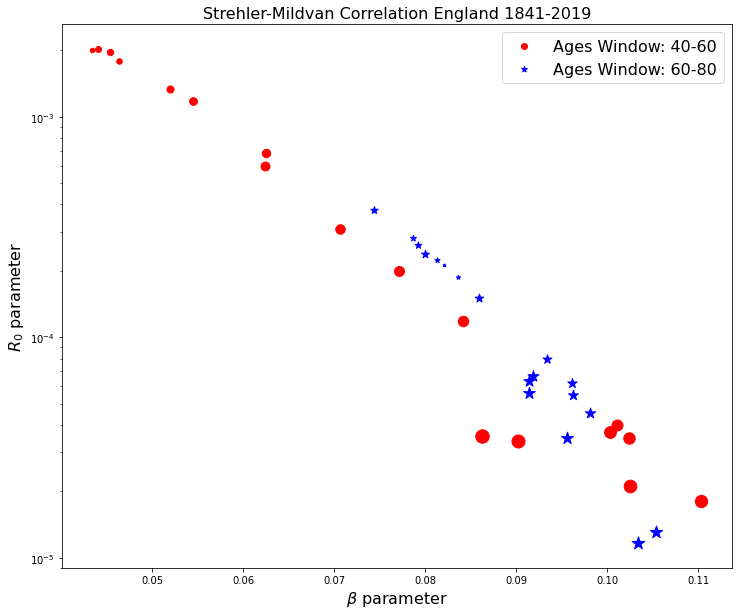

In [425]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(r"Strehler-Mildvan Correlation England 1841-2019" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_England.jpg", dpi = 500)

# FIT ITA

In [427]:
with open('Mx_1x10/ITA.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1872-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

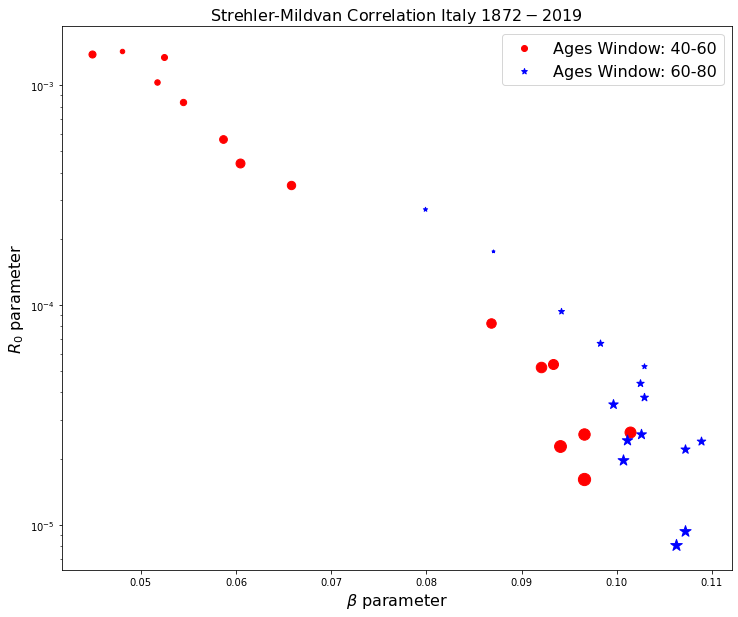

In [428]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Italy $1872-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Italy.jpg", dpi = 500)

# Fit GBR_SCO Scotland

In [429]:
with open('Mx_1x10/GBR_SCO.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1855-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

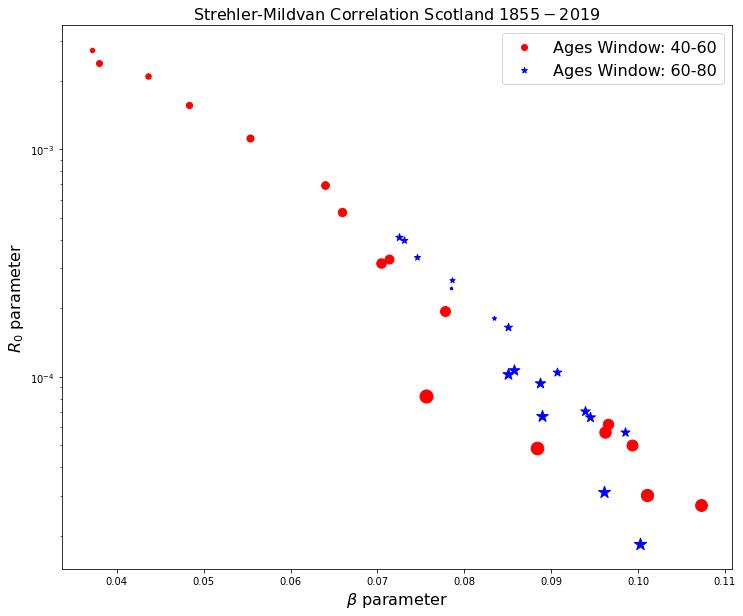

In [430]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Scotland $1855-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Scotland.jpg", dpi = 500)

# Fit ISL Iceland

In [433]:
with open('Mx_1x10/ISL.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1838-1839", "1840-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2021"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

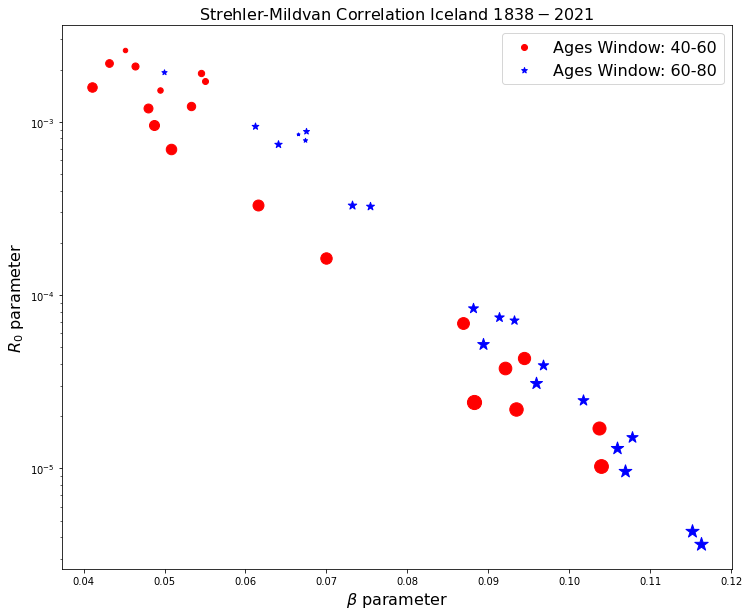

In [435]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Iceland $1838-2021$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Iceland.jpg", dpi = 500)

# Fit NLD Netherlands

In [436]:
with open('Mx_1x10/NLD.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = [ "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

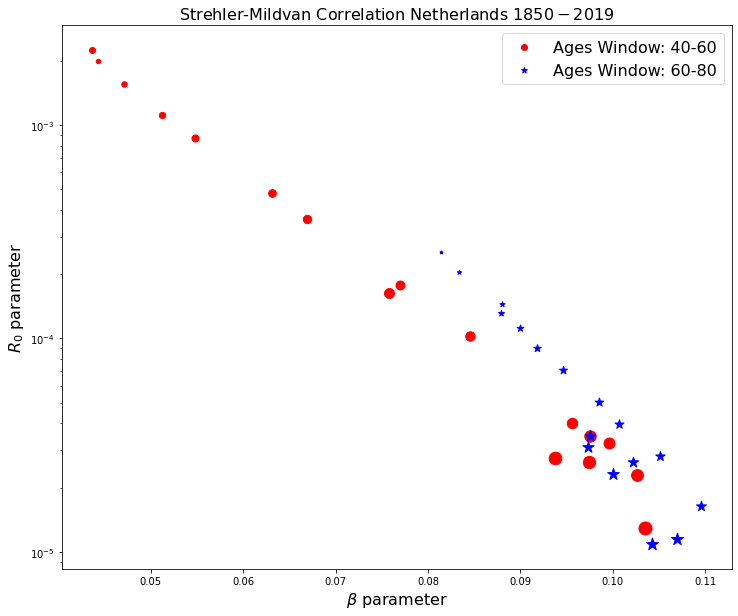

In [437]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Netherlands $1850-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Netherlands.jpg", dpi = 500)

# FIT NOR Norway

In [444]:
with open('Mx_1x10/NOR.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)


years_of_interes = ["1846-1849", "1850-1859", "1860-1869", "1870-1879", "1880-1889", "1890-1899", "1900-1909","1910-1919", "1920-1929","1930-1939" , "1940-1949","1950-1959", "1960-1969", "1970-1979","1980-1989", "1990-1999", "2000-2009", "2010-2019", "2020-2022"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

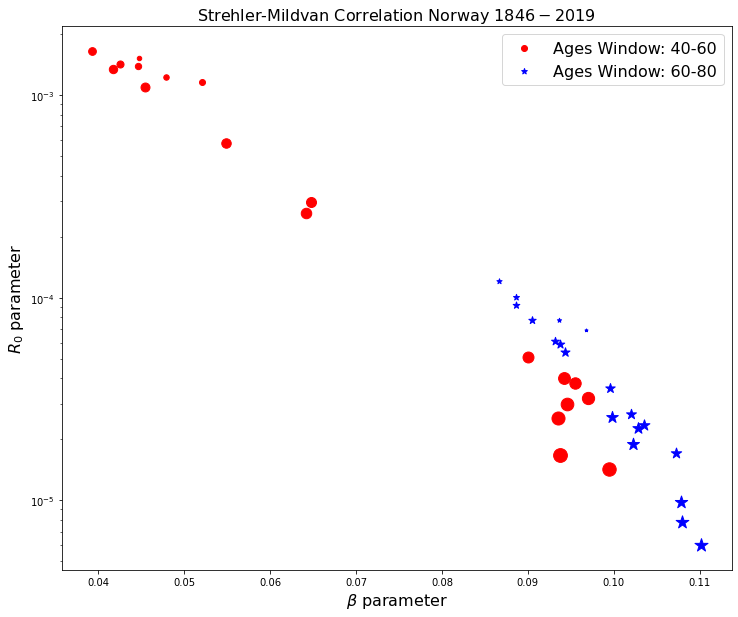

In [445]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.e**(b * x) 

R_parameter_gompertz_law_40_60 = []
R_parameter_gompertz_law_60_80 = []

betas_gompertz_law_40_60 = []
betas_gompertz_law_60_80 = []


for year in years_of_interes:
    edad_40_60 = datos_generales["Ages"][40:60]
    data_40_60 = datos_generales[year][40:60]
    popt_40_60, pcov_40_60 = curve_fit(func, edad_40_60, data_40_60, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_40_60.append(popt_40_60[0])
    betas_gompertz_law_40_60.append(popt_40_60[1])

    edad_60_80 = datos_generales["Ages"][60:80]
    data_60_80 = datos_generales[year][60:80]
    popt_60_80, pcov_60_80 = curve_fit(func, edad_60_80, data_60_80, bounds=(0, [3., 1., 0.5]))
    R_parameter_gompertz_law_60_80.append(popt_60_80[0])
    betas_gompertz_law_60_80.append(popt_60_80[1])

plt.figure(figsize = (12,10))
plt.title(rf"Strehler-Mildvan Correlation Norway $1846-2019$" , fontsize = 16)
plt.xlabel(r"$\beta$ parameter", fontsize = 16)
plt.ylabel(r"$R_0$ parameter", fontsize = 16)
marker_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]

# Crear un scatter plot con colores diferentes para cada pareja de puntos
for i in range(len(betas_gompertz_law_40_60)):
    plt.scatter(betas_gompertz_law_40_60[i], R_parameter_gompertz_law_40_60[i], color="red", s=marker_sizes[i])
    plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',s=marker_sizes[i])
plt.scatter(betas_gompertz_law_40_60[0], R_parameter_gompertz_law_40_60[0], color="red",label = "Ages Window: 40-60")
plt.scatter(betas_gompertz_law_60_80[i], R_parameter_gompertz_law_60_80[i], color= "blue", marker='*',label = "Ages Window: 60-80")
plt.yscale("log")
plt.legend(fontsize = 16)
plt.savefig("Strehler_Mildvan_correlation_Norway.jpg", dpi = 500)